# Test kissing criterion
#### Interatively plot bots that are kissing

### Written by Matan 20230608

In [1]:
#%matplotlib inline
%matplotlib widget


In [2]:
#############imports######################################################################
import cv2 as cv2
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import trackpy as tp
from ipywidgets import HBox, Textarea, interact


In [3]:
################functions1##################################################################
def l2n(x):
    return np.array(x)
def parseCircles(circles):
    x = []
    y = []
    r = []
    for i in range(len(circles[0])):
        x.append(circles[0][i,0])
        y.append(circles[0][i,1])
        r.append(circles[0][i,2])
        
    x,y,r = l2n(x), l2n(y),l2n(r)
    return x,y,r

In [4]:
#########################functions2#########################################################
def preProcessFrame(frame):
    #blur and grayout a frame
    
    # Convert to grayscale.
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
      
    # Convert to HSV and extract the saturation channel
    #sat = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)[:,:,0]

    # median filter
    #median = cv2.medianBlur(gray, 3)
    #gray_blurred = median
    # Blur using 3 * 3 kernel.
    blurSize = 10#5
    gray_blurred = cv2.blur(gray, (blurSize, blurSize))
    
    return gray_blurred

def detectCircles(frame,minRadius,maxRadius,param1=30,param2=25):
    
    minDist = minRadius-1
    dp = 0.5
    # Apply Hough transform on the blurred image.
    circles = cv2.HoughCircles(frame, 
                cv2.HOUGH_GRADIENT,dp, minDist, param1 = param1,
                param2 = param2, minRadius = minRadius, maxRadius = maxRadius)

    return circles
    
def captureFrame(video,frame_id):
    video.set(cv2.CAP_PROP_POS_FRAMES, frame_id)
    ret, frame = video.read()
    if ret:
        return frame
    else:
        return ret

def drawCircles(circles,ax ):
    if circles is not None:  
    # Convert the circle parameters a, b and r to integers.
    #detected_circles = np.uint16(np.around(detected_circles))
    #fig, ax = plt.subplots() 
        for pt in circles[0, :]:
            a, b, r = pt[0], pt[1], pt[2]
            circle = plt.Circle((a, b), r, color='r',fill=False)
            ax.add_patch(circle)
            #ax.imshow(frame, cmap = 'gray')

def drawCirclesDf(df,ax, style = {'color':'r','fill':False, 'linewidth':2}):
    
    color = style['color']
    fill = style['fill']
    linewidth = style['linewidth']
    for index, row in df.iterrows():
        x,y,r = row.x,row.y,row.r
        circle = plt.Circle((x, y), r, color=color,fill=fill,linewidth=linewidth,alpha=0.5)
        ax.add_patch(circle)

def circlesToDataFrame(circles,frameNum):    
    x,y,r = parseCircles(circles)
    data = {'frame':[int(frameNum)]*len(circles),'x':x,'y':y,'r':r}
    dft = pd.DataFrame(data = data)
    
    return dft


def cropImage(img,x0,y0,width,height):
    return img[y0:y0+height,x0:x0+width,:]
'''def cropImage(img,x0,y0,width,height):
    d = len(img.shape)
    if d==2: #grayscale
        return img[y0:y0+height,x0:x0+width]
    elif d==3: #rgb
        return img[y0:y0+height,x0:x0+width,:]
'''

'def cropImage(img,x0,y0,width,height):\n    d = len(img.shape)\n    if d==2: #grayscale\n        return img[y0:y0+height,x0:x0+width]\n    elif d==3: #rgb\n        return img[y0:y0+height,x0:x0+width,:]\n'

In [5]:
expSumFileName = 'C:\\Users\\User\\Documents\\Eden\\locate_git_code\\two_circles_exp\\two_circles_exp5.csv' #'transportExpSum20230309bots21.csv'
expSum = pd.read_csv(expSumFileName)#,index_col=0)

In [6]:
#########################video_filenames###############################################
#fileName = "D:\Eden\20221208\fronters22\C0486shortLabeled.MP4"

#VERY GOOD

arenaSizePixels = 1080 # [pixels]
arenaSizeCm = 100 # [cm]



### Fetch Experiments details from experiment summary table

In [7]:
expSum.head()

,Unnamed: 0,date,operator,bottype,stars,botNo,bots,firstpassiveDiameter[cm],secondpassiveDiameter[cm],thirdpassiveDiameter[cm],...,comments,backedup,motorVal,production,linkingFileName,botLocatingFileName,botLinkingFileName,miniVideoFileNamePack,locatingFileNamePack,linkingFileNamePack
0,NaN,20231119,Eden,fronter,NaN,NaN,1,12.0,32,NaN,...,draft,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,20231119,Eden,fronter,NaN,NaN,1,12.0,32,NaN,...,draft,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,20231119,Eden,fronter,NaN,NaN,1,12.0,32,NaN,...,draft,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,20231119,Eden,fronter,NaN,NaN,1,12.0,32,NaN,...,draft,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,20231119,Eden,fronter,NaN,NaN,1,12.0,32,NaN,...,draft,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
#Presentable experiments:
expNumFronter = 40 #Good start/end frame 3600
expNumAligner = 37 #Good start/end frame 800,3000

#Choose experiment to test
expNum = 51

In [9]:
row = expSum.iloc[expNum]

#passiveDiameter = row['passiveDiameter[cm]']
passiveDiameter = row['FirstDiameterLocatingFile']
fileNameLoc = row.BotLocatingFile
#fileNameLinked = row.botLinkingFileName#'temporaryLinkingFile.csv'#row.linkingFileName
fileNameLinked = row.linkingFileName
fileNameVideo = row.path

In [10]:
row

Unnamed: 0                                                                  NaN
date                                                                   20240416
operator                                                                   Eden
bottype                                                                 fronter
stars                                                                       NaN
botNo                                                                       5.0
bots                                                                          1
firstpassiveDiameter[cm]                                                   14.0
secondpassiveDiameter[cm]                                                    16
thirdpassiveDiameter[cm]                                                   18.0
folder                                    D:\Eden\new_exp_test_15_11_23\15_4_24
path                            D:\Eden\new_exp_test_15_11_23\15_4_24\C0729.MP4
FirstDiameterLocatingFile               

In [11]:
fileNameLinked

'D:\\Eden\\new_exp_test_15_11_23\\15_4_24\\C0729.MP4_locatedFull20240220_bot_Eden_test.csv_linked.csv'

In [12]:
fileNameLoc

'D:\\Eden\\new_exp_test_15_11_23\\15_4_24\\C0729.MP4_locatedFull20240220_bot_Eden_test.csv'

In [13]:
# Load video file
video = cv2.VideoCapture(fileNameVideo)
# Load locating file
t = pd.read_csv(fileNameLinked)

df = pd.read_csv(fileNameLoc)
#get videos properties
width  = video.get(cv2.CAP_PROP_FRAME_WIDTH )
height = video.get(cv2.CAP_PROP_FRAME_HEIGHT )
fps = video.get(cv2.CAP_PROP_FPS)      # OpenCV v2.x used "CV_CAP_PROP_FPS"
frameCount = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
pixelSize = arenaSizeCm/arenaSizePixels

## Locating params 

In [14]:
plt.ioff()
fig1 = plt.figure()
ax1 = fig1.gca()
#ax.imshow(frame,cmap='Greys')
plt.ion()
#fig1.canvas

In [15]:
xC,yC = 657, 544
xP,yP = 192,801
rA = ((xP-xC)**2+(yP-yC)**2)**0.5

In [16]:
colorFronter = 'blue'#'green'
colorPayload = '#AA336A'

payloadStyle = {'color':colorPayload, 'fill':False, 'linewidth':5}
botStyle = {'color':colorFronter, 'fill':False, 'linewidth':2}
kissingBotStyle = {'color':'red', 'fill':True, 'linewidth':2}

In [17]:
########################################widget_cell#####################################################################################
#fig,ax = plt.subplots()
starting_point=1
frame_step=10
maxFrame = frameCount#20000#frameCount
trailLength = 5000

width = int(1200)
height = int(height)
frameRange= range(starting_point,maxFrame,frame_step)
#minDistSq= range(0,50,1)
minDistSq= range(0,100000,10)
maxDistSq= range(0,100000,10)

@interact(frameNum=frameRange,minDistSq=  minDistSq,maxDistSq=maxDistSq)#df.frame.values)
def drawPassiveParticleOnFrame(frameNum,minDistSq,maxDistSq):
    
    #Fetch located bots in current frame
    dff =df[df.frame==frameNum]
    
    x,y,r = dff.x.values,dff.y.values,dff.r.values
    
    circles = [[x,y,r]]
    img  = captureFrame(video,frameNum)
    #imgCropped =cropImage(img,300,0,width,height)
    imgCropped =cropImage(img,425,0,1075,1080)
    
 
    #Draw background image
    ax1.cla()
    ax1.imshow(imgCropped)
    
    ##### Draw bots' circles #####
    
    #filter out false bots out of arena
    cond = ((dff.x-xC)**2+(dff.y-yC)**2)**0.5<rA/2
    #dff = dff[cond]
    drawCirclesDf(dff,ax1,style=botStyle)
    
    
    drawCirclesDf(dff,ax1,style=botStyle)
    
    ######## Draw payload #######
    #cond = (frameNum-trailLength<t.frame) & (t.frame<frameNum)
    cond = (t.frame<frameNum)
    tC = t[cond]
    if len(tC)==0 :
        tC = t[t.frame==frameNum]
    
    #filter by frame
    cond = df.frame==frameNum
    dfC = df[cond]
    tCC = tC[tC.frame==tC.frame.max()]
    tp.plot_traj(tC,ax=ax1,label=False,plot_style={'color':colorPayload,'alpha':0.5,'zorder':0})
    
    drawCirclesDf(tCC,ax1,style=payloadStyle)
    
    #Draw kissing bots as filled circles
    condKissSq = (((dff.x-tCC.x.values[0])**2+(dff.y-tCC.y.values[0])**2)<=maxDistSq)#&(((dff.x-tCC.x.values[0])**2+(dff.y-tCC.y.values[0])**2)>minDistSq)
    dffKiss = dff[condKissSq]
    drawCirclesDf(dffKiss,ax1,style=kissingBotStyle)
    
    #drawCirclesDf(dfC,ax1)
    #ax.imshow(img, cmap='Greys')
    ax1.axis([0,width,0,height])
HBox([fig1.canvas])

interactive(children=(Dropdown(description='frameNum', options=(1, 11, 21, 31, 41, 51, 61, 71, 81, 91, 101, 11…

In [44]:
df[df.frame==1000].x-t[t.frame==1000].x.values[0]

22511    105.0
22512     81.0
22513    -93.0
22514     12.0
22515      6.0
22516     39.0
22517    -72.0
22518   -108.0
22519     65.0
22520     65.0
22521    -17.0
22522    -75.0
22523    -56.0
22524     39.0
22525    -27.0
22526    101.0
22527    -46.0
22528    -11.0
22529    -82.0
22530    -51.0
22531     81.0
22532   -548.0
Name: x, dtype: float64

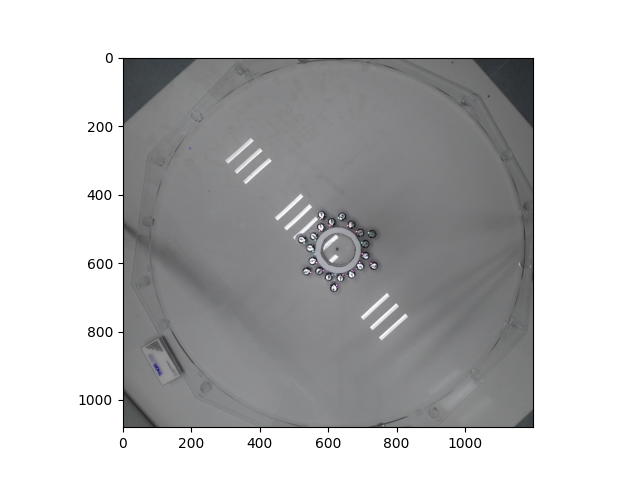

In [45]:
imgCropped =cropImage(captureFrame(video,10),300,0,width,height)
fig2,ax2 = plt.subplots()
ax2.imshow(imgCropped)

In [46]:
for index, row in expSum[expSum.index>16].iterrows():
    print(index, end=', ')

17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 

In [47]:
for index,row in expSum.iterrows():
    print(row.botLinkingFileName)

D:\Eden\29_12_22\aligners_21_7cm\C0548.MP4botLocatedFull20230315.csv_linked.csv
D:\Eden\29_12_22\aligners_21_7cm\C0547.MP4botLocatedFull20230315.csv_linked.csv
D:\Eden\29_12_22\aligners_21_7cm\C0544.MP4botLocatedFull20230315.csv_linked.csv
D:\Eden\29_12_22\aligners_21_7cm\C0542.MP4botLocatedFull20230315.csv_linked.csv
D:\Eden\29_12_22\frontes_21_7cm\C0541.MP4botLocatedFull20230315.csv_linked.csv
D:\Eden\29_12_22\frontes_21_7cm\C0540.MP4botLocatedFull20230315.csv_linked.csv
D:\Eden\29_12_22\frontes_21_7cm\C0539.MP4botLocatedFull20230315.csv_linked.csv
D:\Eden\29_12_22\frontes_21_7cm\C0538.MP4botLocatedFull20230315.csv_linked.csv
D:\Eden\27_12_22\fronters-12cm\C0537.MP4botLocatedFull20230315.csv_linked.csv
D:\Eden\27_12_22\fronters-12cm\C0536.MP4botLocatedFull20230315.csv_linked.csv
D:\Eden\27_12_22\fronters-12cm\C0535.MP4botLocatedFull20230315.csv_linked.csv
D:\Eden\27_12_22\fronters-12cm\C0534.MP4botLocatedFull20230315.csv_linked.csv
D:\Eden\27_12_22\fronters-12cm\C0533.MP4botLocatedFu